In [18]:
pip install pycbc

Note: you may need to restart the kernel to use updated packages.


In [19]:
! pip install lalsuite pycbc

In [20]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [38]:
from pycbc.detector import Detector, get_available_detectors
for abv in get_available_detectors():
    d = Detector(abv)
    print("{} Latitude {} Longitude {}".format(abv,d.latitude,d.longitude))
for ifo1 in ['H1', 'L1', 'V1']:
    for ifo2 in ['H1', 'L1', 'V1']:
        dt = Detector(ifo1).light_travel_time_to_detector(Detector(ifo2))
        print("Direct Time from {} to {} is {} seconds".format(ifo1, ifo2, dt))

T1 Latitude 0.6226733602199997 Longitude 2.43536359469
V0 Latitude 0.7615118398400004 Longitude 0.18333805213
V1 Latitude 0.7615118398400004 Longitude 0.18333805213
G1 Latitude 0.9118498275199999 Longitude 0.17116780435
H2 Latitude 0.8107952638300001 Longitude -2.084056769170001
H1 Latitude 0.8107952638300001 Longitude -2.084056769170001
L1 Latitude 0.5334231350600002 Longitude -1.58430937078
I1 Latitude 0.24841853020052615 Longitude 1.3340133249409993
C1 Latitude 0.5963790054099999 Longitude -2.0617574453799996
E1 Latitude 0.7615118398400004 Longitude 0.18333805213
E2 Latitude 0.7629930799000002 Longitude 0.1840585887
E3 Latitude 0.7627046325699999 Longitude 0.1819299673
E0 Latitude 0.7627046325699999 Longitude 0.1819299673
K1 Latitude 0.6355068497000002 Longitude 2.396441015
U1 Latitude 0.0 Longitude 0.0
A1 Latitude 0.53079879206 Longitude -1.5913706849599998
O1 Latitude 0.79156499342 Longitude 0.20853775679
X1 Latitude 0.81070543755 Longitude 0.10821041362
N1 Latitude 0.7299645671 L

For **LIGO India**, the coordinates are taken from the following reference:

https://dcc.ligo.org/public/0167/T2000158/003/LAO_coordinateSystem.pdf

In [23]:
import matplotlib.pyplot as plt
from pycbc.detector import Detector
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from itertools import combinations
import pandas as pd

ra, dec = np.meshgrid(np.linspace(0, 2 * np.pi, 720),np.linspace(-np.pi / 2, np.pi / 2, 360))
ra = ra.flatten()
dec = dec.flatten()

pol = 0  
t = 1e10  
max_sensitivity = 1.7032270894100685 #for all detectors combined
threshold = .85

#LIGO India
class LigoIndia(Detector):
    def __init__(self, name, latitude, longitude, orientation):
        self.name = name
        self.latitude = latitude
        self.longitude = longitude
        self.orientation = orientation
        super().__init__(name)
ligo_india_latitude = np.radians(19.613306) 
ligo_india_longitude = np.radians(77.030861)  
ligo_india_orientation = np.radians(45.0)  

detectors = [Detector("L1"),Detector("H1"),Detector("K1"),Detector("V1"),
             LigoIndia("I1", ligo_india_latitude, ligo_india_longitude, ligo_india_orientation)]


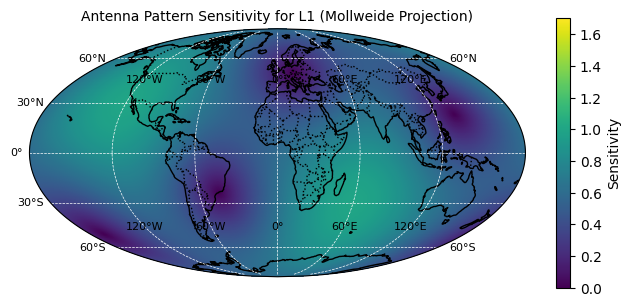

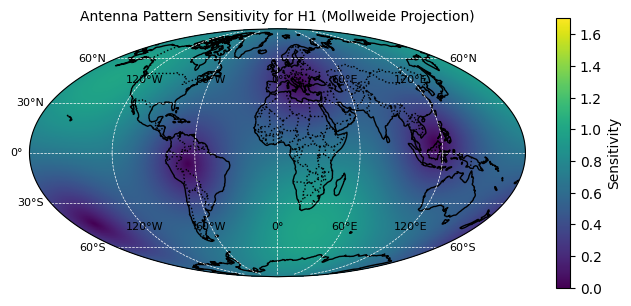

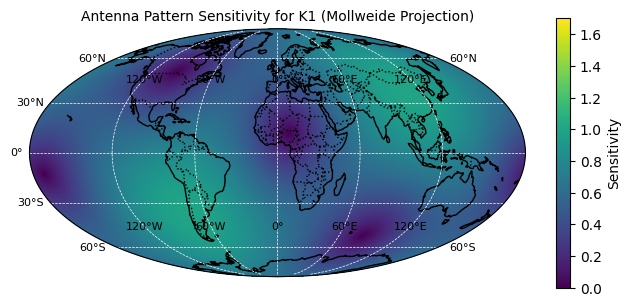

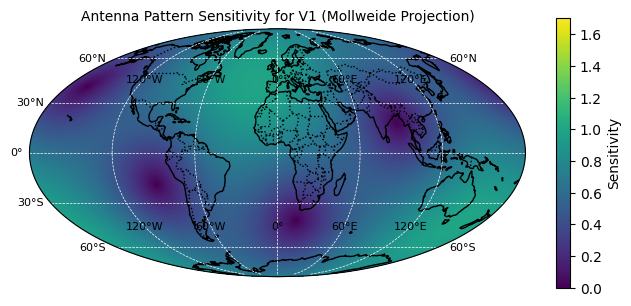

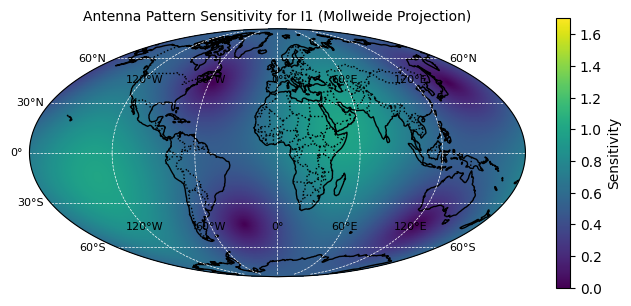

  Detector  Max sensitivity  Area covered (%)
0       L1         0.999994         12.195216
1       H1         0.999998         15.908179
2       K1         0.999996         13.197531
3       V1         0.999991         15.015046
4       I1         0.999999         10.692901


In [39]:
#single detector
table_data = []

for d in detectors:
    fp, fc = d.antenna_pattern(ra, dec, pol, t)
    sensitivity = np.sqrt(fp**2 + fc**2)
    above_threshold = np.sum(sensitivity > threshold)
    total_points = len(sensitivity)
    area_covered = above_threshold*100/total_points
    
    ra_mollweide = ra.copy()
    ra_mollweide[ra > np.pi] -= 2 * np.pi
    ra_deg = np.degrees(ra_mollweide)
    dec_deg = np.degrees(dec)

    fig = plt.figure(figsize=[8, 5])
    ax = fig.add_subplot(111, projection=ccrs.Mollweide())
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.set_global()

    scatter = ax.scatter(ra_deg,dec_deg,c=sensitivity,cmap="viridis",s=2,edgecolors="none",transform=ccrs.PlateCarree(),vmin=0,vmax=max_sensitivity,)
    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="white")
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}
    plt.title(f"Antenna Pattern Sensitivity for {d.name} (Mollweide Projection)", fontsize=10)
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.7, orientation="vertical", pad=0.05)
    cbar.set_label("Sensitivity", fontsize=10)
    plt.show()
    table_data.append({"Detector": f"{d.name}","Max sensitivity": np.max(sensitivity), 
                       "Area covered (%)": area_covered})
table_df = pd.DataFrame(table_data)
print(table_df)



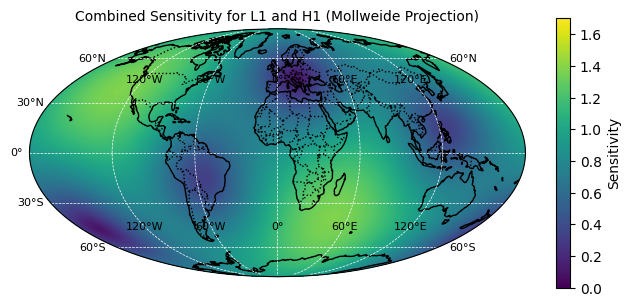

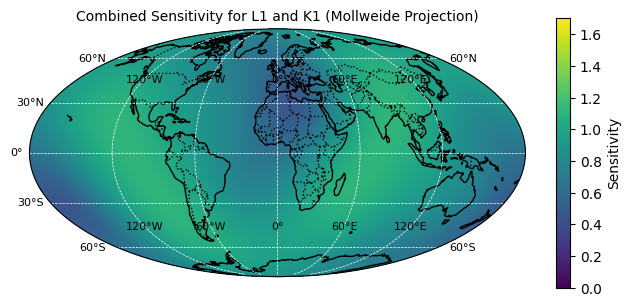

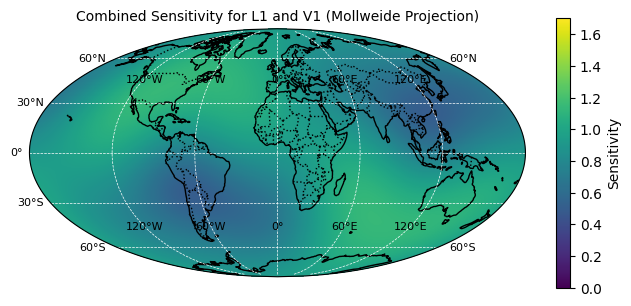

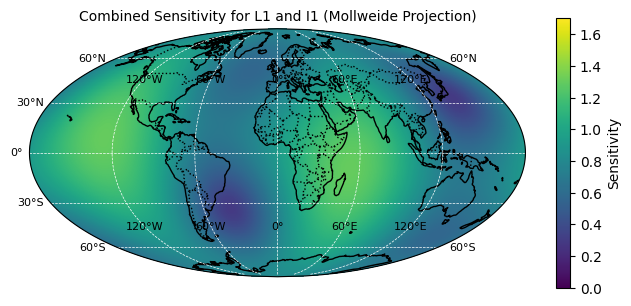

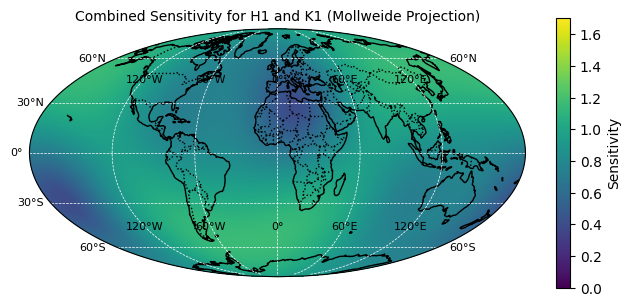

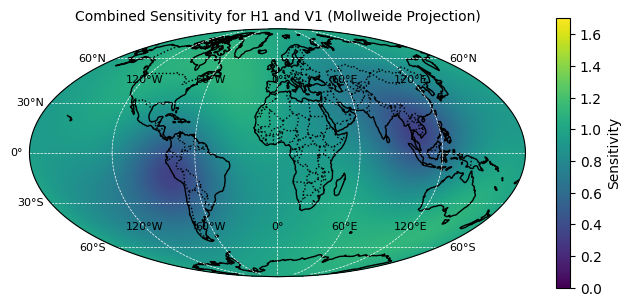

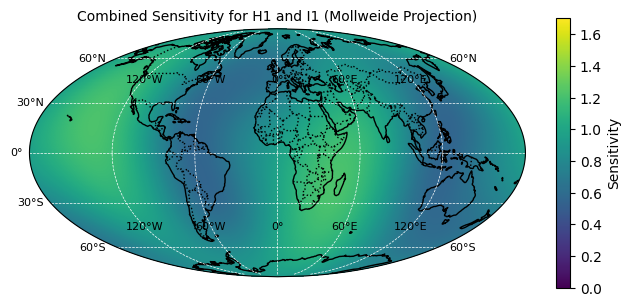

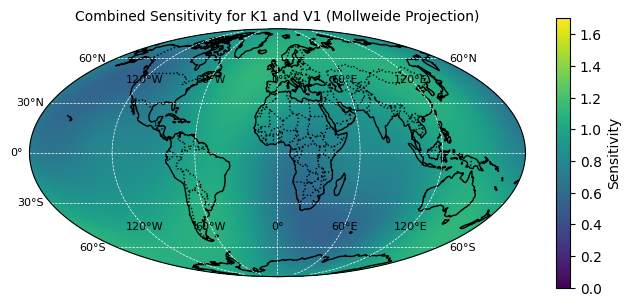

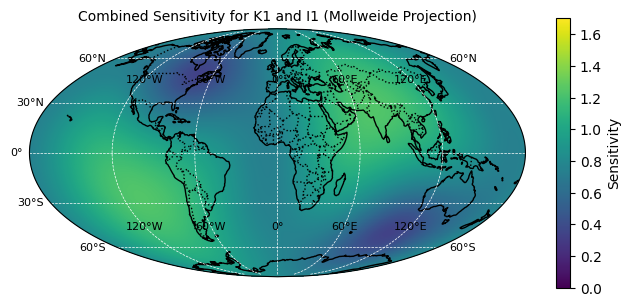

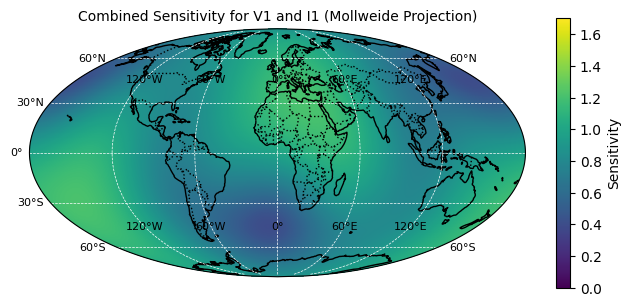

  Detectors  Max Sensitivity  Area Covered (%)
0   L1 + H1         1.374507         53.417052
1   L1 + K1         1.111442         60.523920
2   L1 + V1         1.139518         65.958719
3   L1 + I1         1.301861         38.980324
4   H1 + K1         1.158970         63.687886
5   H1 + V1         1.115027         75.081790
6   H1 + I1         1.221628         58.423611
7   K1 + V1         1.117621         65.599537
8   K1 + I1         1.240739         45.354167
9   V1 + I1         1.214705         55.622685


In [34]:
#two detectors

table_data = []


detector_combo = list(combinations(detectors, 2))

for pair in detector_combo:
    sensitivity_combined = np.zeros(len(ra))  
    for d in pair:
        fp, fc = d.antenna_pattern(ra, dec, pol, t)
        sensitivity = np.sqrt(fp**2 + fc**2)      
        sensitivity_combined += sensitivity**2
    sensitivity_combined = np.sqrt(sensitivity_combined)  
    
    above_threshold = np.sum(sensitivity_combined > threshold)
    total_points = len(sensitivity_combined)
    
    ra_mollweide = ra.copy()
    ra_mollweide[ra > np.pi] -= 2 * np.pi
    ra_deg = np.degrees(ra_mollweide)
    dec_deg = np.degrees(dec)

    fig = plt.figure(figsize=[8, 5])
    ax = fig.add_subplot(111, projection=ccrs.Mollweide())
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.set_global()
    scatter = ax.scatter(ra_deg, dec_deg, c=sensitivity_combined, cmap="viridis", s=2, edgecolors="none", 
                         transform=ccrs.PlateCarree(), vmin=0, vmax=max_sensitivity)
    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="white")
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}
    plt.title(f"Combined Sensitivity for {pair[0].name} and {pair[1].name} (Mollweide Projection)", fontsize=10) 
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.7, orientation="vertical", pad=0.05)
    cbar.set_label("Sensitivity", fontsize=10)
    plt.show() 
    area_covered = above_threshold * 100 / total_points
    table_data.append({"Detectors": f"{pair[0].name} + {pair[1].name}","Max Sensitivity": np.max(sensitivity_combined), 
                       "Area Covered (%)": area_covered})
table_df = pd.DataFrame(table_data)
print(table_df)


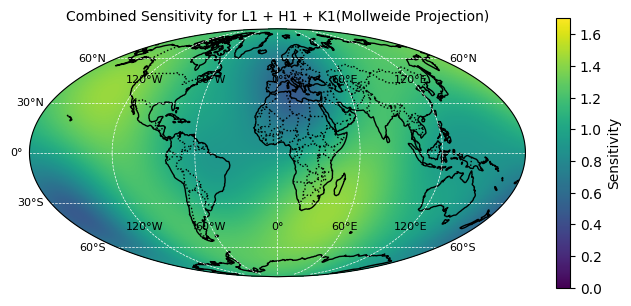

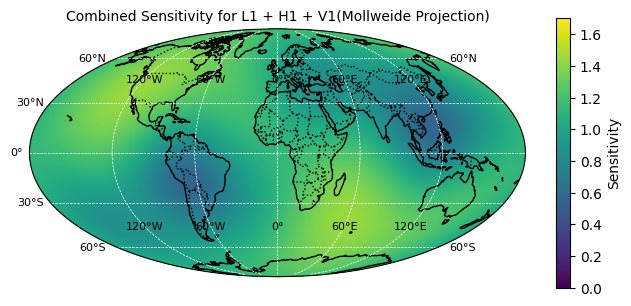

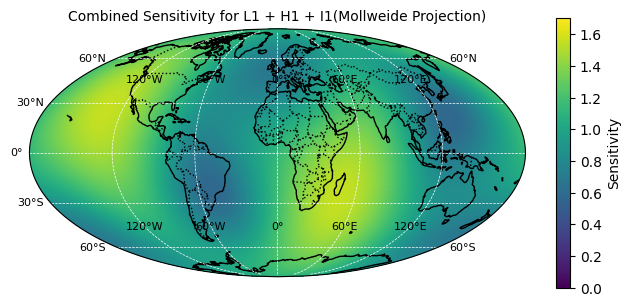

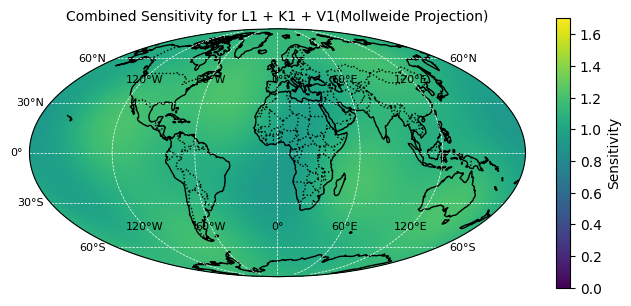

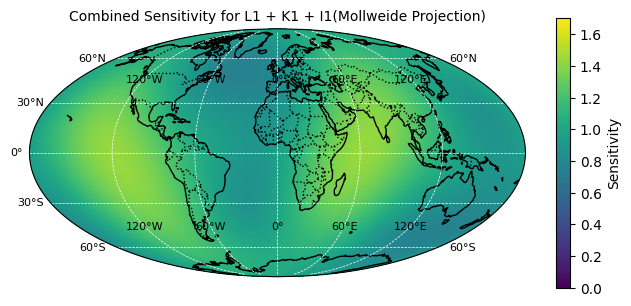

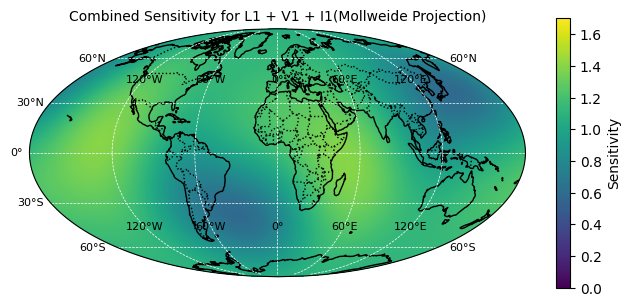

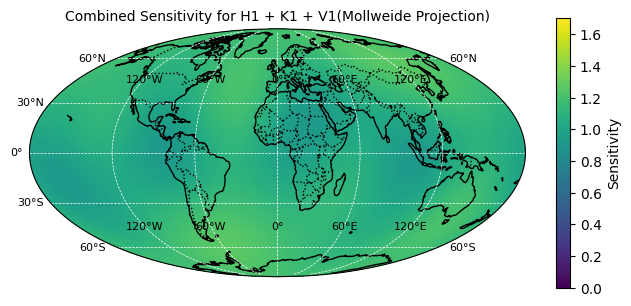

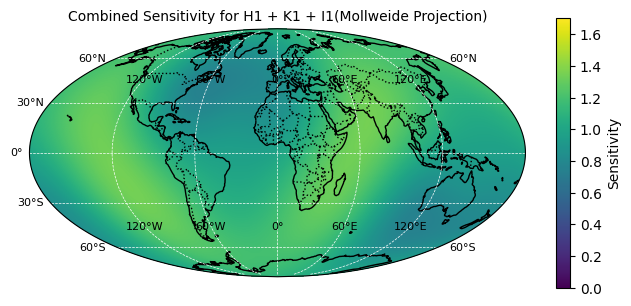

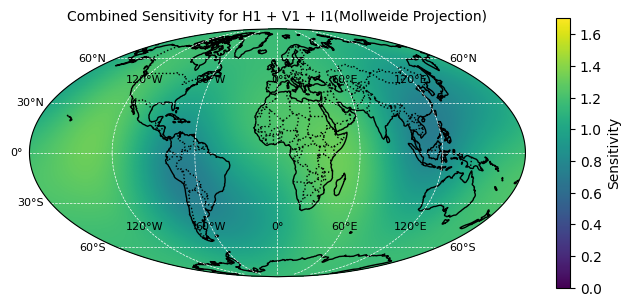

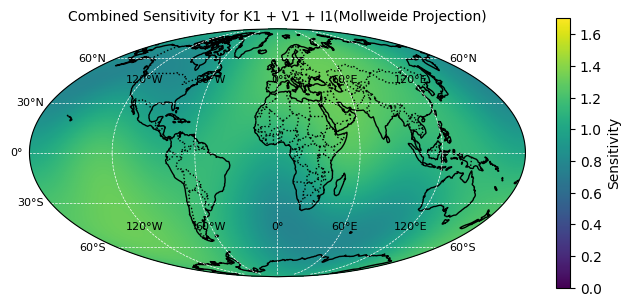

      Detectors  Max Sensitivity  Area Covered (%)
0  L1 + H1 + K1         1.443345         87.636574
1  L1 + H1 + V1         1.442003         90.598380
2  L1 + H1 + I1         1.556820         80.759259
3  L1 + K1 + V1         1.222431        100.000000
4  L1 + K1 + I1         1.437952         90.944059
5  L1 + V1 + I1         1.398100         87.781250
6  H1 + K1 + V1         1.269091        100.000000
7  H1 + K1 + I1         1.344831         89.646991
8  H1 + V1 + I1         1.322540         92.894290
9  K1 + V1 + I1         1.322243         89.856481


In [35]:
# three detectors

table_data = []
detector_combo = list(combinations(detectors, 3))

for triplet in detector_combo:
    sensitivity_combined = np.zeros(len(ra))  
    for d in triplet:
        fp, fc = d.antenna_pattern(ra, dec, pol, t)
        sensitivity = np.sqrt(fp**2 + fc**2)      
        sensitivity_combined += sensitivity**2
    sensitivity_combined = np.sqrt(sensitivity_combined)  
    
    above_threshold = np.sum(sensitivity_combined > threshold)
    total_points = len(sensitivity_combined)
    
    ra_mollweide = ra.copy()
    ra_mollweide[ra > np.pi] -= 2 * np.pi
    ra_deg = np.degrees(ra_mollweide)
    dec_deg = np.degrees(dec)

    fig = plt.figure(figsize=[8, 5])
    ax = fig.add_subplot(111, projection=ccrs.Mollweide())
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.set_global()
    scatter = ax.scatter(ra_deg, dec_deg, c=sensitivity_combined, cmap="viridis", s=2, edgecolors="none", 
                         transform=ccrs.PlateCarree(), vmin=0, vmax=max_sensitivity)
    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="white")
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}
    plt.title(f"Combined Sensitivity for {triplet[0].name} + {triplet[1].name} + {triplet[2].name}(Mollweide Projection)", fontsize=10) 
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.7, orientation="vertical", pad=0.05)
    cbar.set_label("Sensitivity", fontsize=10)
    plt.show() 
    area_covered = above_threshold * 100 / total_points
    table_data.append({"Detectors": f"{triplet[0].name} + {triplet[1].name} + {triplet[2].name}","Max Sensitivity": np.max(sensitivity_combined), 
                       "Area Covered (%)": area_covered})
table_df = pd.DataFrame(table_data)
print(table_df)


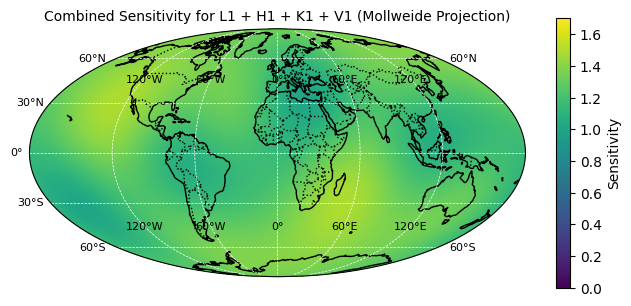

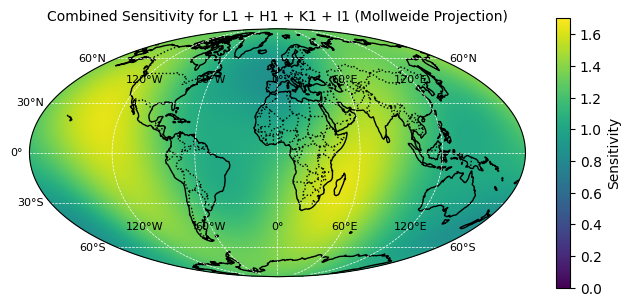

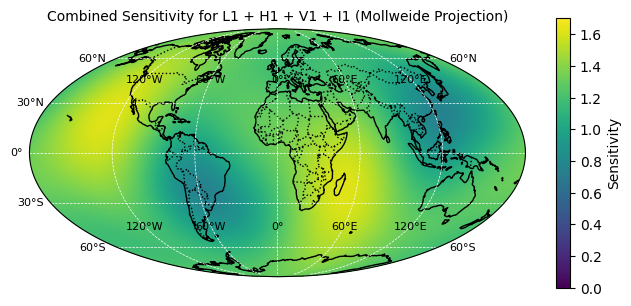

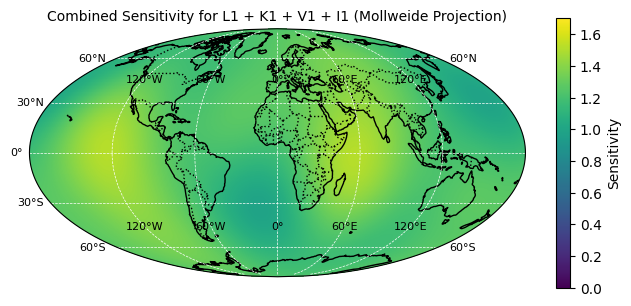

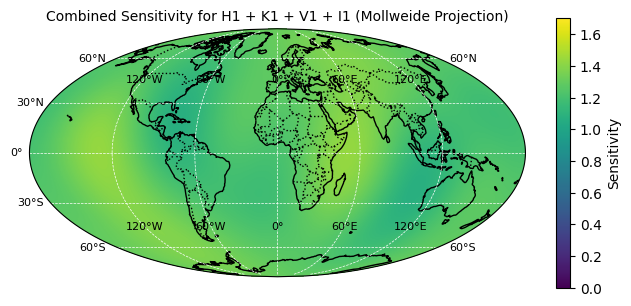

           Detectors  Max Sensitivity  Area Covered (%)
0  L1 + H1 + K1 + V1         1.495295        100.000000
1  L1 + H1 + K1 + I1         1.633874        100.000000
2  L1 + H1 + V1 + I1         1.622517         97.148148
3  L1 + K1 + V1 + I1         1.515900        100.000000
4  H1 + K1 + V1 + I1         1.431612        100.000000


In [36]:
# four detectors

table_data = []
detector_combo = list(combinations(detectors, 4))

for quartet in detector_combo:
    sensitivity_combined = np.zeros(len(ra))  
    for d in quartet:
        fp, fc = d.antenna_pattern(ra, dec, pol, t)
        sensitivity = np.sqrt(fp**2 + fc**2)      
        sensitivity_combined += sensitivity**2
    sensitivity_combined = np.sqrt(sensitivity_combined)  
    
    above_threshold = np.sum(sensitivity_combined > threshold)
    total_points = len(sensitivity_combined)
    
    ra_mollweide = ra.copy()
    ra_mollweide[ra > np.pi] -= 2 * np.pi
    ra_deg = np.degrees(ra_mollweide)
    dec_deg = np.degrees(dec)
    fig = plt.figure(figsize=[8, 5])
    ax = fig.add_subplot(111, projection=ccrs.Mollweide())
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.set_global()
    scatter = ax.scatter(ra_deg, dec_deg, c=sensitivity_combined, cmap="viridis", s=2, edgecolors="none", 
                         transform=ccrs.PlateCarree(), vmin=0, vmax=max_sensitivity)
    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="white")
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}
    plt.title(f"Combined Sensitivity for {quartet[0].name} + {quartet[1].name} + {quartet[2].name} + {quartet[3].name} (Mollweide Projection)", fontsize=10) 
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.7, orientation="vertical", pad=0.05)
    cbar.set_label("Sensitivity", fontsize=10)
    plt.show() 
    area_covered = above_threshold * 100 / total_points
    table_data.append({"Detectors": " + ".join([d.name for d in quartet]),"Max Sensitivity": np.max(sensitivity_combined), 
                       "Area Covered (%)": area_covered})
table_df = pd.DataFrame(table_data)
print(table_df)


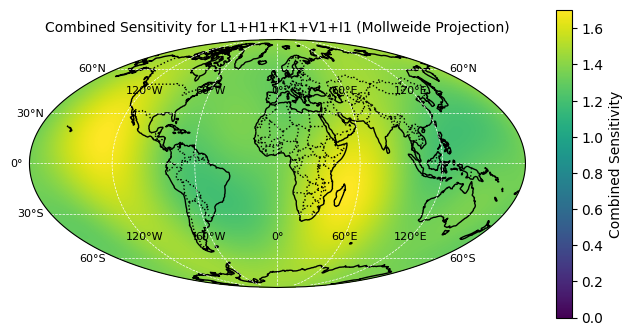

Maximum Combined Sensitivity: 1.7032270894100685
Area covered (%):  100.0


In [37]:
# all 5 detectors

sensitivity_combined = np.zeros(len(ra))
for d in detectors:
    fp, fc = d.antenna_pattern(ra, dec, pol, t)
    sensitivity = np.sqrt(fp**2 + fc**2)
    sensitivity_combined += sensitivity**2 
sensitivity_combined = np.sqrt(sensitivity_combined)  

ra_mollweide = ra.copy()
ra_mollweide[ra > np.pi] -= 2 * np.pi
ra_deg = np.degrees(ra_mollweide)
dec_deg = np.degrees(dec)

fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111, projection=ccrs.Mollweide())
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
ax.set_global()
scatter = ax.scatter(ra_deg, dec_deg, c=sensitivity_combined, cmap="viridis", s=2, edgecolors="none", 
                         transform=ccrs.PlateCarree(), vmin=0, vmax=max_sensitivity)
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="white")
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 8}
gl.ylabel_style = {"size": 8}
plt.title("Combined Sensitivity for L1+H1+K1+V1+I1 (Mollweide Projection)", fontsize=10)
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, orientation="vertical", pad=0.05)
cbar.set_label("Combined Sensitivity", fontsize=10)
plt.show()

print("Maximum Combined Sensitivity:", np.max(sensitivity_combined))
print("Area covered (%): ",area_covered)